# Pandas + Scikit workflow

Ever since I started doing machine learning I was torn apart between Python and R. R is extremely easy at the beginning and you might create a simple model in a matter of minutes. 

Python + [Scikit](http://scikit-learn.org/stable/) + [Pandas](http://pandas.pydata.org/) has definitely steeper learning curve. At this point, I prefer Python over R as I find more explicit. It's harder but if you use it properly it's simpler once you start doing something more serious as different libraries tend to play together well.

I will present here how I prefer structuring my explorative Python scripts using [`Pipeline`](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html), [`sklearn.preprocessing.*`](scikit-learn.org/stable/modules/preprocessing.html), `Pandas` dataframes and [`sklearn-pandas`](https://github.com/paulgb/sklearn-pandas) bridge library.

If you want to play with the code, go ahead and download the .ipynb source of this blogpost.

# Preprocessing

Let's go through an example from Kaggle, the [Titanic](https://www.kaggle.com/c/titanic) dataset. The task here is to predict who will survive on Titanic, based on a subset of whole dataset.

What I care about is to do as much data preprocessing as possible in Pandas as it's easy to validate the results of it and unlike using numpy, you can manipulate the data based on column names instead of column indexes. A byproduct of that is, that you arrive at a R-ready dataframe and you can e.g. do some explorative analysis using [ggplot2](ggplot2.org).

If you wish to see the gist only, go directly to the first usage of `Pipeline`.

In [1]:
from __future__ import division
import csv as csv
import numpy as np

import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import KFold, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import LabelEncoder, LabelBinarizer

from sklearn_pandas import DataFrameMapper

Let's load the data from Kaggle Titanic competition.

In [2]:
df_train = pd.read_csv('train.csv', header = 0, index_col = 'PassengerId')
df_test = pd.read_csv('test.csv', header = 0, index_col = 'PassengerId')
df = pd.concat([df_train, df_test], keys=["train", "test"])

I concatenated `df_train` and `df_test` above.
This simplifies dealing with any with missing data, creating new features and such as I do it once for the whole dataset. 
Note also the `index_col` argument - this tremendously helps when performing `merges`.

In [4]:
df['Title'] = df['Name'].apply(lambda c: c[c.index(',') + 2 : c.index('.')])
df['LastName'] = df['Name'].apply(lambda n: n[0:n.index(',')])
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
df.loc[df['Embarked'].isnull(), 'Embarked'] = df['Embarked'].mode()[0]
df.loc[df['Fare'].isnull(), 'Fare'] = df['Fare'].mode()[0]
df['FamilyID'] = df['LastName'] + ':' + df['FamilySize'].apply(str)
df.loc[df['FamilySize'] <= 2, 'FamilyID'] = 'Small_Family'

df['AgeOriginallyNaN'] = df['Age'].isnull().astype(int)
medians_by_title = pd.DataFrame(df.groupby('Title')['Age'].median()) \
  .rename(columns = {'Age': 'AgeFilledMedianByTitle'})
df = df.merge(medians_by_title, left_on = 'Title', right_index = True) \
  .sort_index(level = 0).sort_index(level = 1)

Have you noticed I used multiindex when creating `df`? Now, it's simple to split it back!

In [5]:
df_train = df.ix['train']
df_test  = df.ix['test']

The purpose of `featurize` function above is to create dummy variables out of categorical ones. In `Scikit` we must be explicit about it as the algorithms accept only `float` variables.

In [6]:
def featurize(features):
  transformations = [
                            ('Embarked', LabelBinarizer()),
                            ('Fare', None),
                            ('Parch', None),
                            ('Pclass', LabelBinarizer()),
                            ('Sex', LabelBinarizer()),
                            ('SibSp', None),                                       
                            ('Title', LabelBinarizer()),
                            ('FamilySize', None),
                            ('FamilyID', LabelBinarizer()),
                            ('AgeOriginallyNaN', None),
                            ('AgeFilledMedianByTitle', None)]

  return DataFrameMapper(filter(lambda x: x[0] in df.columns, transformations))


In [7]:
features = ['Sex', 'Title', 'FamilySize', 'AgeFilledMedianByTitle',
            'Embarked', 'Pclass', 'FamilyID', 'AgeOriginallyNaN']

pipeline = Pipeline([('featurize', featurize(features)), ('forest', RandomForestClassifier())])

The `pipeline` is a concatenation of transformer `featurize` and classifier `forest`. 

Note, I used `sklearn-pandas` `DataFrameMapper` adapter to bridge `sklearn` and `pandas` in a seamless way. Now I can put `Pandas` data frames right into the pipeline to fit the model. No awkward jumping from `Pandas` and `SciKit` back and forth!

In [8]:
X = df_train[df_train.columns.drop('Survived')]
y = df_train['Survived']
model = pipeline.fit(X = X, y = y)

Note, that I put the pandas dataframe `X` and `y` directly, without explicitly transforming into numpy array.

I can reuse the pipeline for prediction and rely on pipeline to perform label binarizations the same way it was done for training.

In [9]:
prediction = model.predict(df_test)

# Fruits - model exploration
In R, some of these steps would be easier. For example instead of playing with dummy variables, one would simply use `Survived ~ Sex + Title + FamilySize + ... + AgeOriginallyNaN` and the algorithms would treat factor variables properly. 

In `Scikit` we had to laboriously prepare the data and pipeline. Let's see what laverage does it provide.

### Modifying model
Creating a model with different set of features or different classifier is very simple.

In [10]:
simple_pipeline = Pipeline([('featurize', featurize(['Sex'])), ('lm', LogisticRegression())])
model = simple_pipeline.fit(X = X, y = y).predict(df_test)

### Cross validation
Say we want to do k fold cross validation to validate our model. According to [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.cross_val_score.html#sklearn.cross_validation.cross_val_score) this should perform a 3-fold cross validation.

In [11]:
cross_val_score(pipeline, X, y, 'accuracy')

array([ 0.74747475,  0.8013468 ,  0.82491582])

Looks good! How about k-fold stratified cross validation ?

In [12]:
stratified_kfold = StratifiedKFold(df_train['Survived'] == 1, n_folds = 10)
cross_val_score(simple_pipeline, X, y, 'accuracy', cv = stratified_kfold)

array([ 0.82222222,  0.83333333,  0.78651685,  0.87640449,  0.83146067,
        0.79775281,  0.82022472,  0.78651685,  0.87640449,  0.85227273])

That impresses me!

### Hyperparameters optimization
We have 3 algorithms implemented in `Scikit` to choose from. Let's try Grid Search.

In [18]:
features = ['Sex', 'Title', 'FamilySize', 'AgeFilledMedianByTitle',
            'Embarked', 'Pclass', 'FamilyID', 'AgeOriginallyNaN']

pipeline = Pipeline([('featurize', featurize(features)), ('forest', RandomForestClassifier(n_estimators = 10))])

pipeline.fit(X, y).predict(df_train)

param_grid = dict(forest__n_estimators = [2, 16, 32], forest__criterion = ['gini', 'entropy'])

grid_search = GridSearchCV(pipeline, param_grid=param_grid, scoring='accuracy')

best_pipeline = grid_search.fit(X, y).best_estimator_
best_pipeline.get_params()['forest']


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=16, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Turns out the best parameters are: `n_estimators=32` and `crieterion=gini`. 

Oh wait but how is it scored? The `cv` argument is unset, so we are at 3-fold cross-validation. Let's try out stratified cross validation.

In [15]:
grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv = stratified_kfold, scoring='accuracy')
best_pipeline = grid_search.fit(X, y).best_estimator_
best_pipeline.get_params()['forest']

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=16, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Oh, now we got `criterion=gini` but `n_estimators=16`.
If you want to verify that indeed stratified 10-fold cross validation was performed, you can set e.g. `verbose = 10` as argument to `GridSearchCV`.

### Interfacing with R
Last but not least structuring the code like I did above gives makes laveraging R using `rpy2` very simple, as you have a R ready variables, mainly `df`, `df_test` and `df_train`. 

I myself do that to plot using R's excellent `ggplot`.

In [16]:
%load_ext rpy2.ipython
%Rpush df

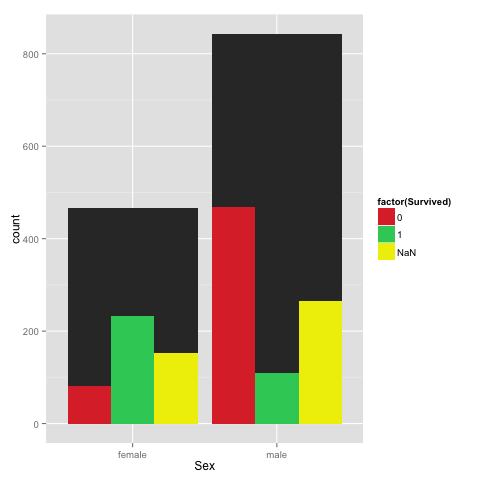

In [17]:
%%R
library(ggplot2)

ggplot(df) +
  geom_bar(aes(Sex), stat = "bin") + 
  geom_bar(aes(Sex, fill = factor(Survived)), stat = "bin", position = "dodge") +
  scale_fill_manual(values=c("#DD3333", "#33CC66", "#eeee00"))

# Summary

The last thing that I am missing in this picture is mapping between column names in pandas dataframe and column indexes in numpy arrays. That would be very useful if you want to e.g. display a tree from random forest for inspection.

Let me know if you know a way!